In [1]:
import numpy as np
import pandas as pd
import os, glob
from scipy.signal import hilbert
from scipy import optimize
import matplotlib.pyplot as plt

In [2]:
plt.rcParams["font.family"] = "Arial"
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
plt.rcParams['axes.linewidth'] = 2 # set the value globally
plt.rcParams['figure.dpi'] = 200

In [3]:
def get_hilbert_trans(signal: np.ndarray, fs: float, unwrap: bool=False) -> np.ndarray:
    analytic_signal = hilbert(signal)
    HT_imag = np.imag(analytic_signal)
    amplitude_envelope = np.abs(analytic_signal)
    if unwrap:
        instantaneous_phase = np.unwrap(np.angle(analytic_signal))
    else:
        instantaneous_phase = np.angle(analytic_signal)
    instantaneous_frequency = (np.diff(instantaneous_phase) /(2.0*np.pi) * fs)
    return instantaneous_phase

def remove_nan(data: np.ndarray)-> np.ndarray:
    data_out = data[~np.isnan(data)]
    return data_out

def get_damping_from_phase(phase_shift: np.ndarray) -> np.ndarray:
    r'''
    Damping ratio -[%]
    '''
    return np.sin(np.abs(phase_shift/2)) *100

def get_ts_dmin_xu(stress_raw: np.ndarray, 
                strain_raw: np.ndarray, 
                dt: float=0.002,
                freq: float=0.5) -> np.ndarray:
    
    def fit_data(x: np.ndarray, a: float, f: float, fi: float) -> np.ndarray:
        y = a*np.sin(2*np.pi*f*x-fi)
        return y
    stress_amp = np.max(stress_raw)
    strain_amp = np.max(strain_raw)
    time = np.linspace(0, len(stress_raw)*dt, len(stress_raw))
    print(len(time))

    p0_ini = [strain_amp, freq, 0.0001] #Initial value of a,f,fi
    param_bounds = ([strain_amp*0.8, freq*0.99, 0], [strain_amp*1.5, freq*1.01, 2*np.pi]) #the parameter boundary
    popt, pcov = optimize.curve_fit(fit_data, time, strain_raw, p0=p0_ini,bounds=param_bounds)
    a_strain = popt[0]
    f_strain = popt[1]
    fi_strain = popt[2]
    print('Strain Parameters')
    print(a_strain, f_strain, fi_strain)

    stress_fit = fit_data(time, stress_amp, freq, 0)
    strain_fit = fit_data(time, a_strain, freq, fi_strain)
    return stress_fit, strain_fit

## `Small-Strain` Example - Synthetic Motion

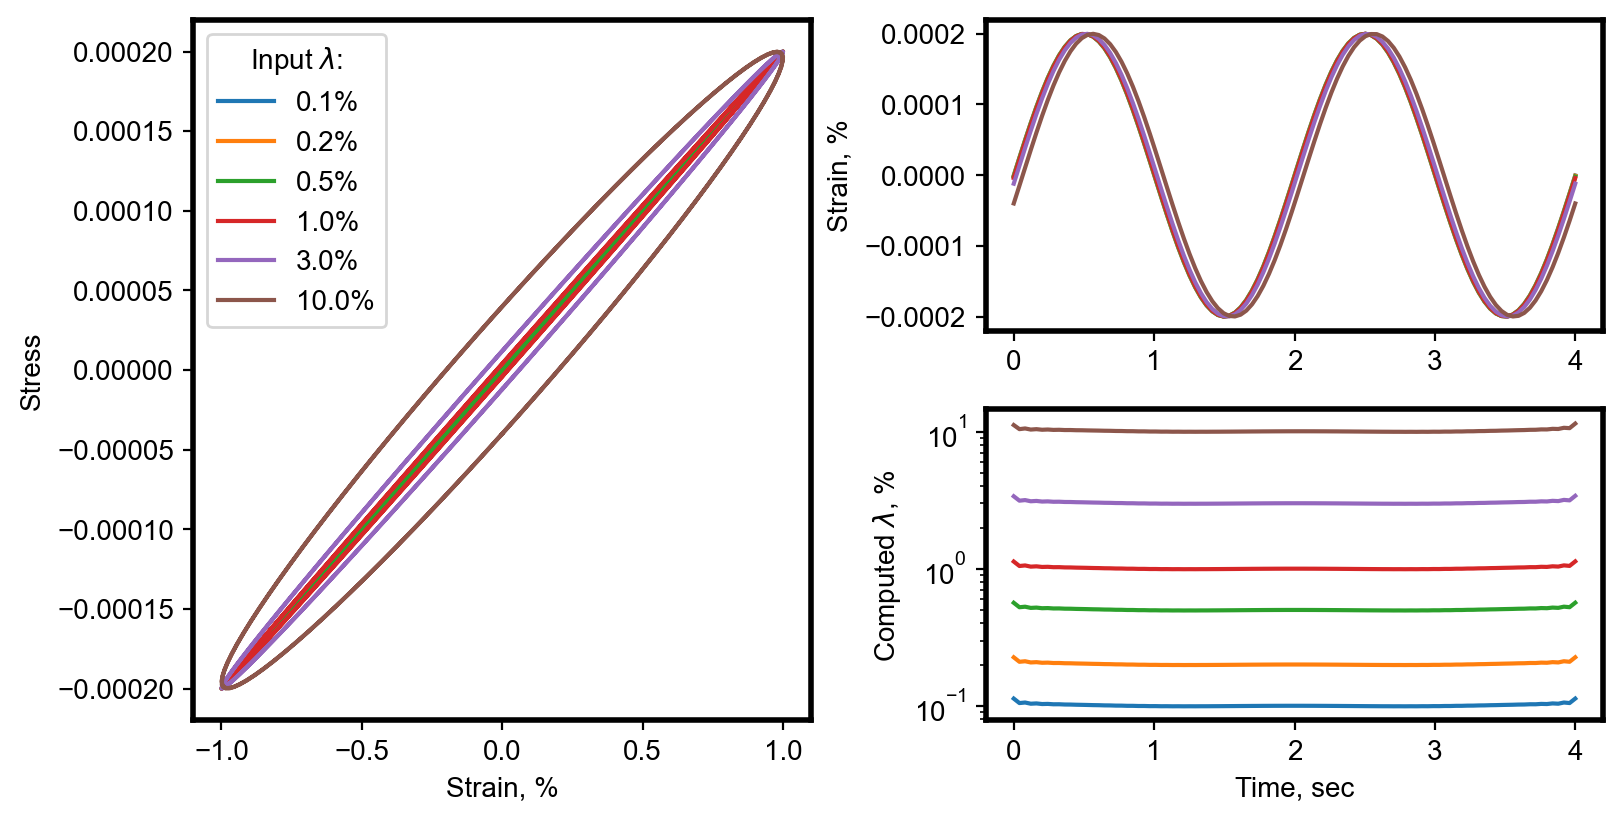

In [5]:
freq = 0.5 #excitation -[Hz]
fs = 25 #sampling frequency -[Hz]
cycle = 2
damping_list = [0.1, 0.2, 0.5, 1.0, 3.0,10.0] #-[%]
phase_shift_list = [np.arcsin(2*x/100) for x in damping_list]
time = np.linspace(0, cycle/freq, int(cycle/freq*fs))
stress = np.sin(2*np.pi*freq*time)
phase_stress = get_hilbert_trans(stress, fs)
fig, axs = plt.subplot_mosaic([['a', 'b'], ['a', 'c']], layout='constrained', figsize=(8, 4))
axs['a'].set_xlabel('Strain, %')
axs['a'].set_ylabel('Stress')
axs['b'].set_ylabel('Strain, %')
axs['c'].set_ylabel(r'Computed $\lambda$, %')
axs['c'].set_xlabel('Time, sec')
axs['c'].set_yscale('log')
for damping_input, phase_shift_input in zip(damping_list, phase_shift_list):
    strain = 0.0002*np.sin(2*np.pi*freq*time - phase_shift_input)
    phase_strain = get_hilbert_trans(strain, fs)
    phase_shift_HT = phase_strain - phase_stress
    damping = get_damping_from_phase(phase_shift_HT)
    axs['a'].plot(stress, strain, label=f'{damping_input}%')
    axs['b'].plot(time, strain, label=f'{damping_input}%' )
    axs['c'].plot(time, damping, label=f'{damping_input}%' )
axs['a'].legend(title=r'Input $\lambda$:', loc='best')
plt.show()
plt.close()

## `Small-Strain` Data from Torsional Shear Testing

In [7]:
filepath = os.path.join(os.path.dirname(os.getcwd()), 'LabData', 'SmallStrainTS.xlsx')
df = pd.read_excel(filepath)
df = df[df.Stress != 0]
stress = df.Stress.to_numpy()
strain = df.Strain.to_numpy()
time = df.Time.to_numpy()
fs = 1/(time[1]-time[0])
dt = time[1]-time[0]
time = np.linspace(0, len(stress)*dt, len(stress))
print(len(time))

11000


In [8]:
phase_shift_stress = get_hilbert_trans(stress, fs)
phase_shift_strain = get_hilbert_trans(strain, fs)
phase_shift = phase_shift_strain - phase_shift_stress
damping = get_damping_from_phase(phase_shift)
len(damping)


11000

In [9]:
stress_fit, strain_fit = get_ts_dmin_xu(stress, strain)

11000
Strain Parameters
0.00014722857565587042 0.4998812938056073 0.0695057434850115


In [10]:
phase_shift_stress = get_hilbert_trans(stress_fit, fs)
phase_shift_strain = get_hilbert_trans(strain_fit, fs)
phase_shift_xu = phase_shift_strain - phase_shift_stress
damping_xu = get_damping_from_phase(phase_shift_xu)
len(damping_xu)

11000

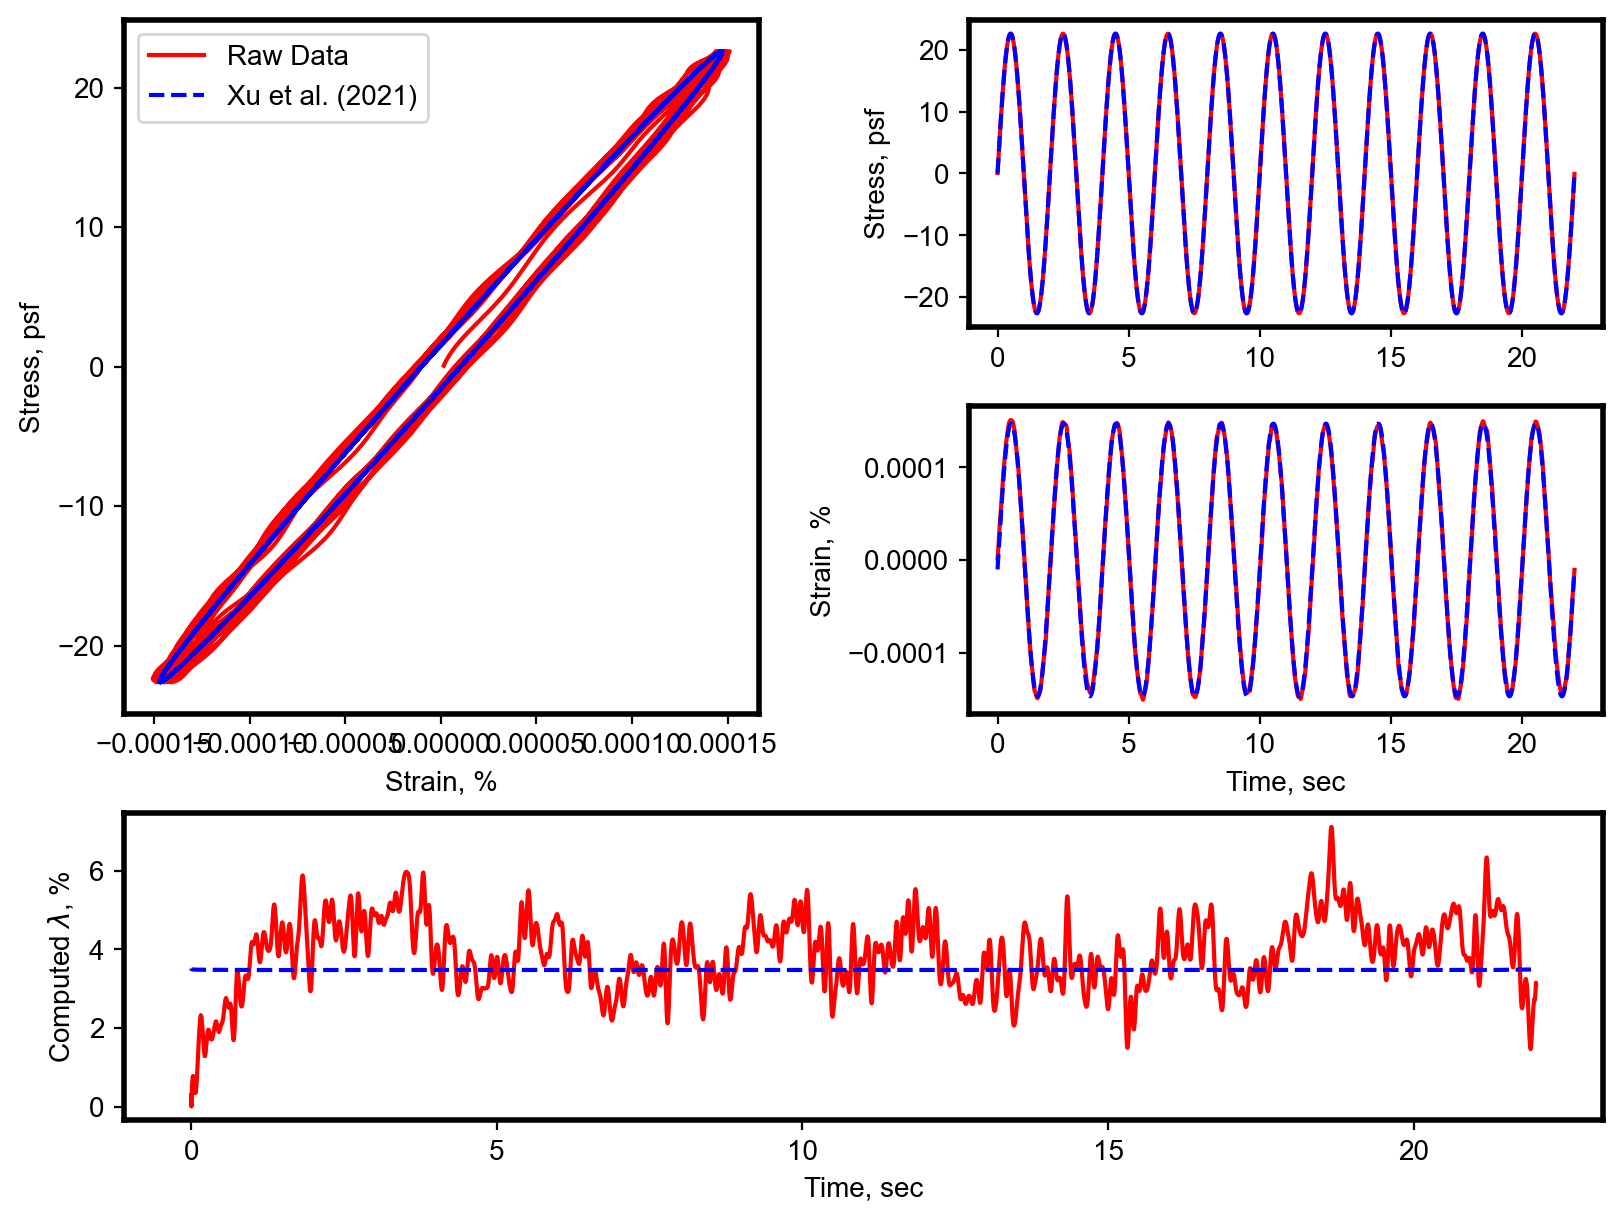

In [15]:
fig, axs = plt.subplot_mosaic([['a', 'b'], ['a', 'c'], ['d', 'd']], layout='constrained', figsize=(8, 6))
axs['a'].set_xlabel('Strain, %')
axs['a'].set_ylabel('Stress, psf')
axs['b'].set_ylabel('Stress, psf')
axs['c'].set_ylabel('Strain, %')
axs['d'].set_ylabel(r'Computed $\lambda$, %')
axs['c'].set_xlabel('Time, sec')
axs['d'].set_xlabel('Time, sec')
axs['a'].plot(strain, stress, color='r', label='Raw Data')
axs['a'].plot(strain_fit, stress_fit, color='blue', label='Xu et al. (2021)', ls='--')
axs['b'].plot(time, stress, color='r')
axs['b'].plot(time, stress_fit, color='b', ls='--')
axs['c'].plot(time, strain, color='r')
axs['c'].plot(time, strain_fit, color='b', ls='--')
axs['d'].plot(time, damping, color='r')
axs['d'].plot(time, damping_xu, color='blue', ls='--')
axs['a'].legend(loc='best')
plt.show()

## `Nonlinear` from Torsional Shear Testing

In [24]:
filepath = os.path.join(os.path.dirname(os.getcwd()), 'LabData', 'TS_Liquefaction.xlsx')
df = pd.read_excel(filepath)
df = df[df.Stress != 0]
stress = df.Stress.to_numpy()
strain = df.Strain.to_numpy()
time = df['Time,s'].to_numpy()
fs = 1/(time[1]-time[0])
dt = time[1]-time[0]
time = np.linspace(0, len(stress)*dt, len(stress))
freq = 0.5

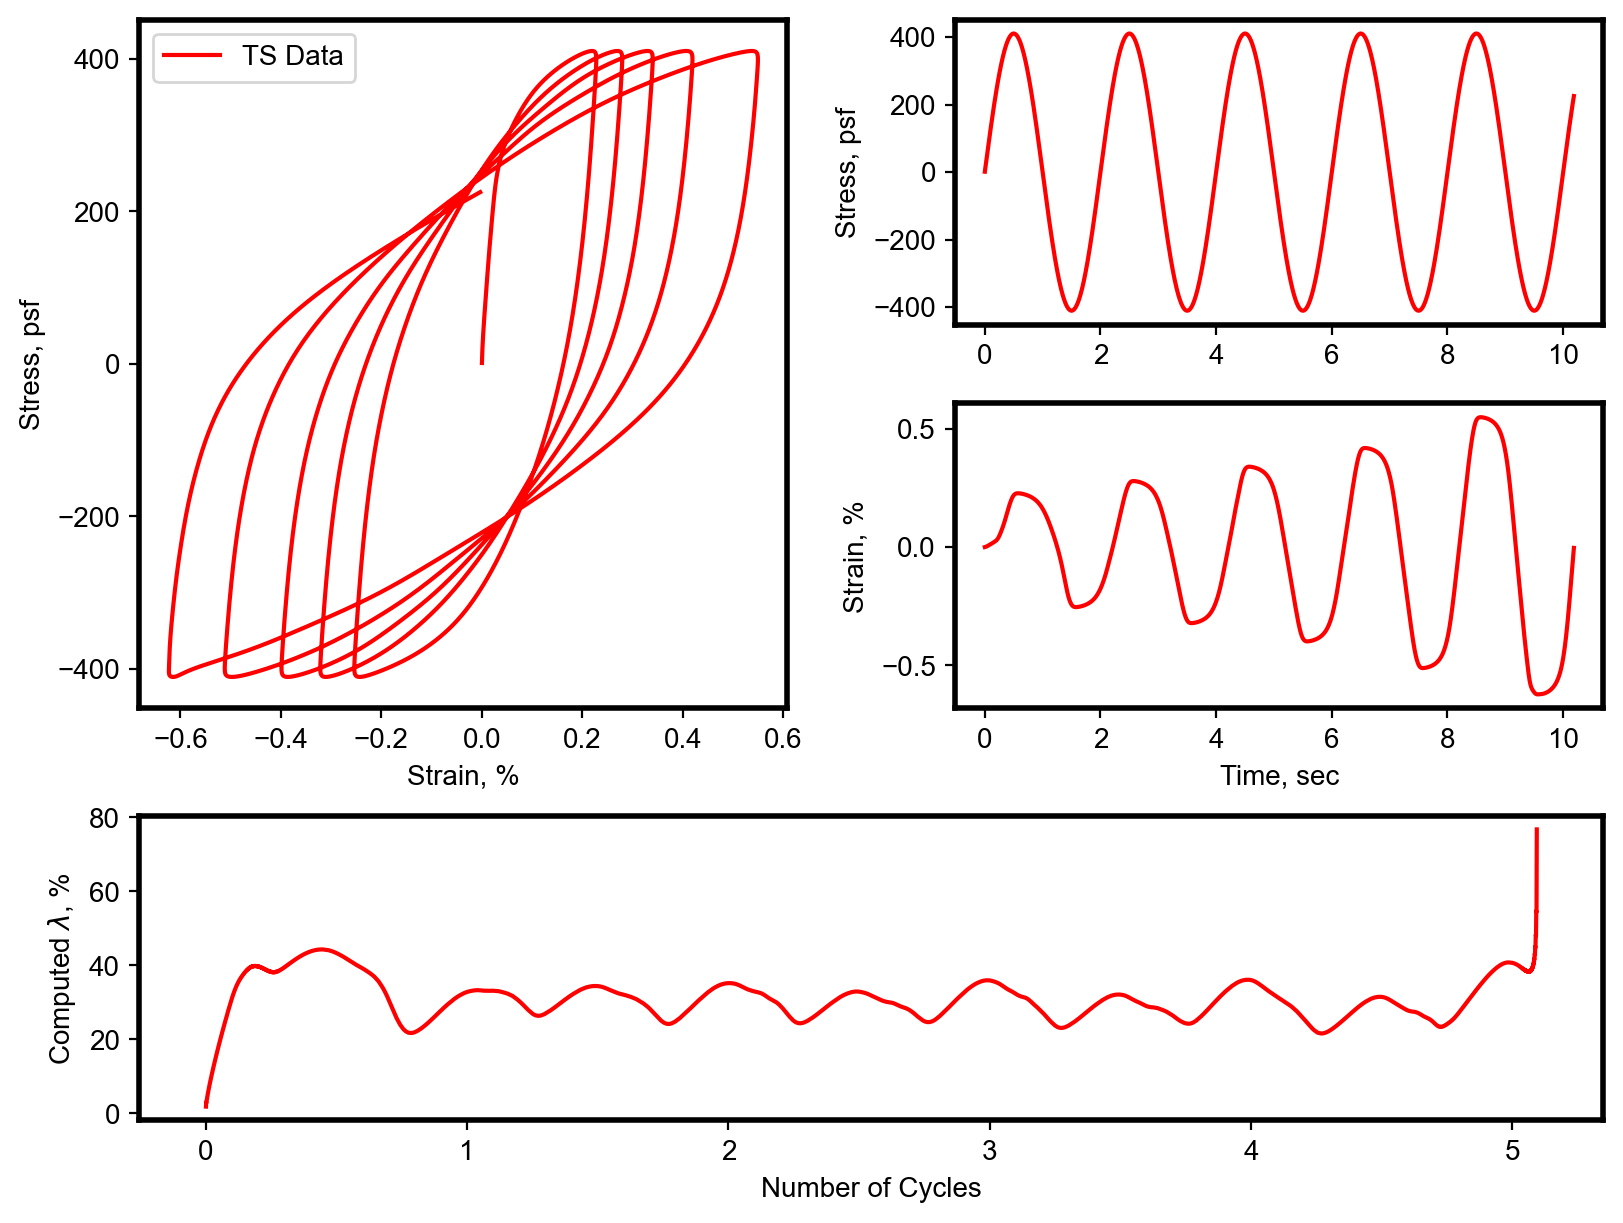

In [27]:
phase_shift_stress = get_hilbert_trans(stress, fs)
phase_shift_strain = get_hilbert_trans(strain, fs)
phase_shift = phase_shift_strain - phase_shift_stress
damping = get_damping_from_phase(phase_shift)

fig, axs = plt.subplot_mosaic([['a', 'b'], ['a', 'c'], ['d', 'd']], layout='constrained', figsize=(8, 6))
axs['a'].set_xlabel('Strain, %')
axs['a'].set_ylabel('Stress, psf')
axs['b'].set_ylabel('Stress, psf')
axs['c'].set_ylabel('Strain, %')
axs['d'].set_ylabel(r'Computed $\lambda$, %')
axs['c'].set_xlabel('Time, sec')
axs['d'].set_xlabel('Number of Cycles')
axs['a'].plot(strain, stress, color='r', label='TS Data')
#axs['a'].plot(strain_fit, stress_fit, color='blue', label='Xu et al. (2021)', ls='--')
axs['b'].plot(time, stress, color='r')
#axs['b'].plot(time, stress_fit, color='b', ls='--')
axs['c'].plot(time, strain, color='r')
#axs['c'].plot(time, strain_fit, color='b', ls='--')
axs['d'].plot(time[1:]*freq, damping[1:], color='r')
#axs['d'].plot(time, damping_xu, color='blue', ls='--')
axs['a'].legend(loc='best')
plt.show()

## `Nonlinear` from Cyclic Triaxial with One-Way Softening